In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## 날씨 데이터세트

In [2]:
# data_path = '/content/drive/MyDrive/Colab_Timeseries/data/sample.csv'
data_path = '/content/drive/MyDrive/Colab_Architecture/data/ASOS_108_20090101_20161231.csv'
_null_df = pd.read_csv(data_path)
null_df = _null_df.drop(columns=['Unnamed: 0'])
df = null_df.interpolate()
df.drop(columns=['rnum', 'stnId', 'stnNm'], inplace=True)
date_time = pd.to_datetime(df.pop('tm'), format='%Y-%m-%d %H:%M')

In [3]:
is_null = df.isnull().sum().sum()
if not is_null:
    display(df.head())
else:
    print("결측치가 완전히 처리되지 않았습니다.")

,ta,rn,ws,wd,hm,pv,td,pa,ps,ss,icsr
0,-7.6,0.0,2.1,290.0,55.0,1.9,-15.0,1013.7,1024.9,0.0,0.0
1,-7.8,0.0,2.3,320.0,54.0,1.8,-15.5,1013.7,1024.9,0.0,0.0
2,-8.1,0.0,2.0,340.0,52.0,1.7,-16.2,1013.8,1025.1,0.0,0.0
3,-8.5,0.0,2.4,290.0,52.0,1.7,-16.6,1014.2,1025.5,0.0,0.0
4,-8.8,0.0,2.1,320.0,53.0,1.7,-16.6,1014.3,1025.6,0.0,0.0


In [4]:
date_time

0       2009-01-01 00:00:00
1       2009-01-01 01:00:00
2       2009-01-01 02:00:00
3       2009-01-01 03:00:00
4       2009-01-01 04:00:00
                ...        
70122   2016-12-31 19:00:00
70123   2016-12-31 20:00:00
70124   2016-12-31 21:00:00
70125   2016-12-31 22:00:00
70126   2016-12-31 23:00:00
Name: tm, Length: 70127, dtype: datetime64[ns]

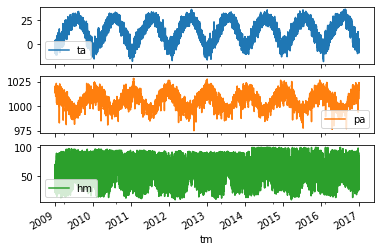

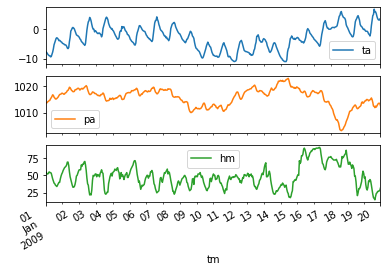

In [5]:
plot_cols = ['ta', 'pa', 'hm']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

### 검사 및 정리하기

다음으로 데이터세트의 통계를 살펴봅니다.

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ta,70127.0,12.822554,11.191880,-18.0,3.5,14.0,22.60,36.40
rn,70127.0,0.160988,1.380714,0.0,0.0,0.0,0.00,71.00
ws,70127.0,2.612271,1.413425,0.0,1.6,2.4,3.40,11.40
wd,70127.0,190.800676,109.928402,0.0,70.0,230.0,290.00,360.00
hm,70127.0,60.251073,19.864594,9.0,45.0,60.0,76.00,100.00
pv,70127.0,11.214524,8.117957,0.6,4.2,9.1,17.30,35.40
td,70127.0,4.525626,12.352965,-28.3,-5.2,5.6,15.20,26.90
pa,70127.0,1005.839323,8.024067,975.1,999.6,1006.0,1012.10,1028.20
ps,70127.0,1016.114898,8.443696,984.4,1009.5,1016.2,1022.70,1039.60
ss,70127.0,0.255317,0.407925,0.0,0.0,0.0,0.60,1.00


### 특성 엔지니어링

모델을 본격적으로 빌드하기 전에 데이터를 이해하고 모델에 적절한 형식의 데이터를 전달하는 것이 중요합니다.

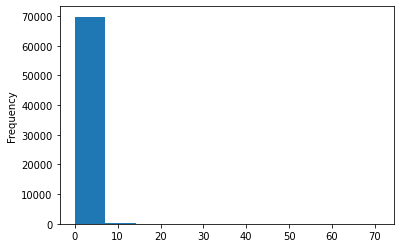

In [7]:
df['rn'].plot.hist()
plt.show()

#### 바람

데이터의 마지막 열인 `wd (deg)`는 도 단위로 바람의 방향을 나타냅니다. 각도가 있으면 모델 입력으로 좋지 않으므로 360°와 0°는 서로 가까워야 하며 부드럽게 휘어져야 합니다. 바람이 불지 않으면 방향은 중요하지 않습니다.

현재, 바람 데이터의 분포는 다음과 같습니다.

Text(0, 0.5, 'Wind Velocity [m/s]')

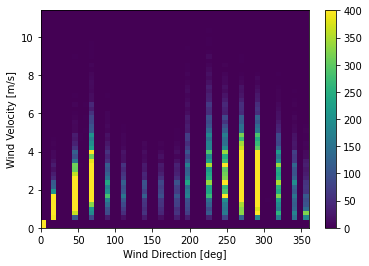

In [8]:
plt.hist2d(df['wd'], df['ws'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

그러나 풍향과 속도 열을 바람 **벡터**로 변환하면 모델이 해석하기가 더 쉽습니다.

In [9]:
wv = df.pop('ws')

# Convert to radians.
wd_rad = df.pop('wd')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

바람 벡터의 분포는 모델이 올바르게 해석하기에 훨씬 더 간단합니다.

(-10.712495876959357,
 7.8934180146016315,
 -10.712495876959357,
 10.14868030448781)

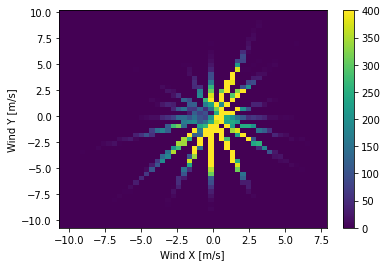

In [10]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

#### 시간

마찬가지로 `Date Time` 열은 매우 유용하지만 이 문자열 형식으로는 유용하지 않습니다. 우선 초로 변환합니다.

In [11]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

In [12]:
timestamp_s

0        1.230768e+09
1        1.230772e+09
2        1.230775e+09
3        1.230779e+09
4        1.230782e+09
             ...     
70122    1.483211e+09
70123    1.483214e+09
70124    1.483218e+09
70125    1.483222e+09
70126    1.483225e+09
Name: tm, Length: 70127, dtype: float64

풍향과 유사하게 초 단위의 시간은 유용한 모델 입력이 아닙니다. 날씨 데이터이므로 하루 및 연 단위의 주기성이 명확합니다. 주기성을 처리할 수 있는 방법에는 여러 가지가 있습니다.

사용 가능한 신호로 변환하는 간단한 방법은 `sin` 및 `cos`를 사용하여 시간을 명확한 "하루 중 시간" 및 "연중 시간" 신호로 변환하는 것입니다.

In [13]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

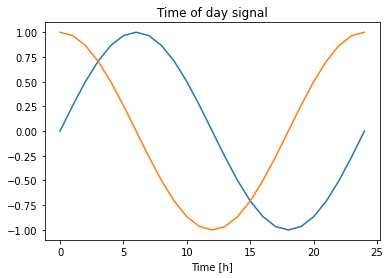

In [14]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

Text(0.5, 1.0, 'Time of year signal')

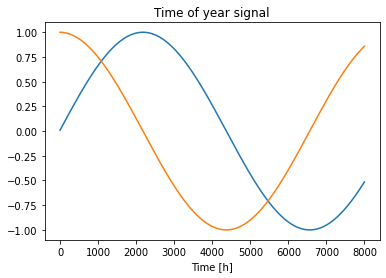

In [15]:
plt.plot(np.array(df['Year sin'])[:8000])
plt.plot(np.array(df['Year cos'])[:8000])
plt.xlabel('Time [h]')
plt.title('Time of year signal')

그러면 모델이 가장 중요한 빈도 특성에 액세스할 수 있습니다. 이 경우 어떤 빈도가 중요한지 미리 알고 있었습니다.

모르는 경우 `fft`를 사용하여 중요한 빈도를 결정할 수 있습니다. 시간에 따른 온도의 `tf.signal.rfft`를 보면 여기서 가정한 내용이 확인됩니다. `1/year` 및 `1/day` 근처에서 빈도 피크가 확실하다는 것을 알 수 있습니다. 

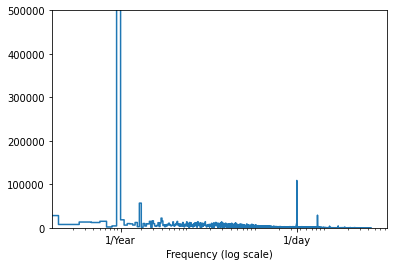

In [16]:
fft = tf.signal.rfft(df['ta'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['ta'])
hours_per_year = 24*365.2524
# hours_per_year = 24*365
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 5e+5)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [17]:
df = df[['Year sin', 'Year cos', 'Day sin', 'Day cos', 'ta', 'rn', 'hm', 'pv', 
        'td', 'pa', 'ps', 'ss', 'icsr', 'Wx', 'Wy']]
if True:
    df.drop(columns=['rn'], inplace=True)

In [18]:
df.head()

,Year sin,Year cos,Day sin,Day cos,ta,hm,pv,td,pa,ps,ss,icsr,Wx,Wy
0,0.009332,0.999956,-1.776611e-12,1.000000,-7.6,55.0,1.9,-15.0,1013.7,1024.9,0.0,0.0,0.718242,-1.973355
1,0.010049,0.999950,2.588190e-01,0.965926,-7.8,54.0,1.8,-15.5,1013.7,1024.9,0.0,0.0,1.761902,-1.478412
2,0.010766,0.999942,5.000000e-01,0.866025,-8.1,52.0,1.7,-16.2,1013.8,1025.1,0.0,0.0,1.879385,-0.684040
3,0.011483,0.999934,7.071068e-01,0.707107,-8.5,52.0,1.7,-16.6,1014.2,1025.5,0.0,0.0,0.820848,-2.255262
4,0.012199,0.999926,8.660254e-01,0.500000,-8.8,53.0,1.7,-16.6,1014.3,1025.6,0.0,0.0,1.608693,-1.349854


### 데이터 분할

훈련, 검증 및 테스트 세트에 `(70%, 20%, 10%)` 분할을 사용합니다. 분할하기 전에 데이터가 임의로 셔플되지 **않습니다**. 이것은 두 가지 이유 때문입니다.

1. 데이터를 연속된 샘플의 창으로 자르는 것이 여전히 가능합니다.
2. 모델을 훈련한 후 수집된 데이터를 바탕으로 평가하므로 검증/테스트 결과가 보다 현실적입니다.

In [19]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [20]:
num_features

14

### 데이터 정규화

신경망을 훈련하기 전에 특성의 크기를 정하는 것이 중요합니다. 정규화는 이 크기 조정을 수행하는 일반적인 방법입니다. 평균을 빼고 각 특성의 표준 편차로 나눕니다.

모델이 검증 및 테스트 세트의 값에 액세스할 수 없도록 훈련 데이터를 사용해서만 평균 및 표준 편차를 계산해야 합니다.

또한 모델이 훈련할 때 훈련 세트의 미래 값에 액세스할 수 없어야 하고 이 정규화가 이동 평균을 사용하여 수행되어야 한다고 말할 수도 있습니다. 이 내용은 본 튜토리얼의 중점 사항이 아니며, 검증 및 테스트 세트가 있기 때문에 (다소) 정직한 메트릭을 얻을 수 있습니다. 따라서 단순화를 위해 이 튜토리얼에서는 단순 평균을 사용합니다.

In [21]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

이제 특성의 분포를 살펴봅니다. 일부 특성은 꼬리가 길지만 `-9999` 풍속 값과 같은 명백한 오류는 없습니다.

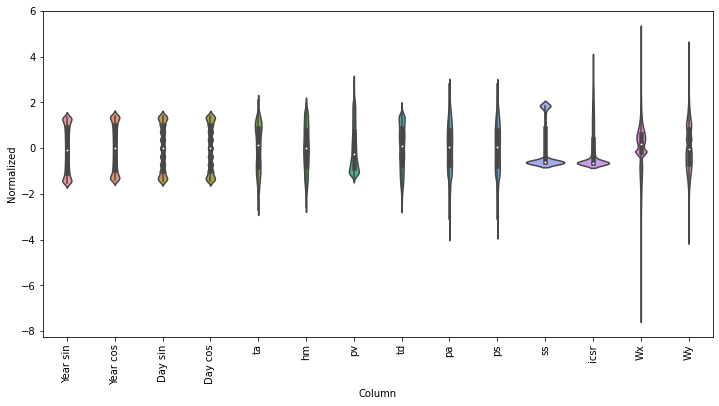

In [22]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [23]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in 
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

이 섹션의 시작 부분에서 다이어그램에 나타낸 두 개의 창을 만드는 코드는 다음과 같습니다.

In [24]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['ta'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['ta']

In [25]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['ta'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['ta']

In [26]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

# 클래스 정의 이후 메서드 추가
# https://stackoverflow.com/questions/972/adding-a-method-to-an-existing-object-instance
WindowGenerator.split_window = split_window

다음을 사용해 보세요.

In [27]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 14)
Inputs shape: (3, 6, 14)
labels shape: (3, 1, 1)


일반적으로 TensorFlow의 데이터는 가장 바깥 쪽 인덱스가 여러 예제("배치" 차원)에 걸쳐 있는 배열로 구성됩니다. 중간 인덱스는 "시간" 또는 "공간"(너비, 높이) 차원입니다. 가장 안쪽 인덱스는 특성입니다.

위의 코드는 두 배치의 7-타임스텝 창을 사용하며 각 타임스텝에는 19개의 특성이 있습니다. 그러면 이것을 한 배치의 6-타임스텝과 19개의 특성 입력 및 1-타임스텝 1-특성 레이블로 분할합니다. 레이블에는 하나의 특성만 있는데, `WindowGenerator`가 `label_columns=['T (degC)']`로 초기화되었기 때문입니다. 우선 이 튜토리얼에서는 단일 출력 레이블을 예측하는 모델을 빌드합니다.

In [28]:
w2.input_slice, w2.labels_slice, w1.input_slice, w1.labels_slice

(slice(0, 6, None),
 slice(6, None, None),
 slice(0, 24, None),
 slice(47, None, None))

In [29]:
np.arange(w2.total_window_size)[w2.input_slice], \
np.arange(w2.total_window_size)[w2.labels_slice], \
np.arange(w1.total_window_size)[w1.input_slice], \
np.arange(w1.total_window_size)[w1.labels_slice] 

(array([0, 1, 2, 3, 4, 5]),
 array([6]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 array([47]))

### 3. 플롯하기

다음은 분할 창을 간단하게 시각화할 수 있는 플롯 메서드입니다.

In [30]:
w2.example = example_inputs, example_labels

In [31]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

이 플롯은 항목이 참조하는 시간을 기준으로 입력, 레이블 및 (나중에) 예측값을 정렬합니다.

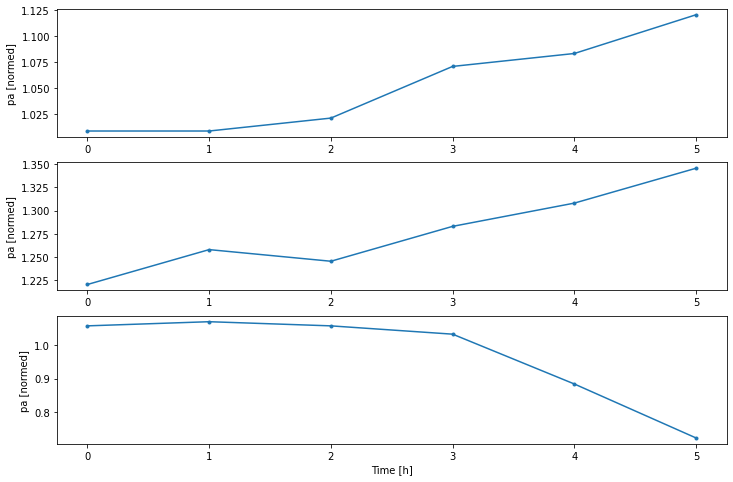

In [32]:
w2.plot(plot_col='pa')

다른 열을 플롯할 수 있지만 예제 창 `w2` 구성에는 `T (degC)` 열에 대한 레이블만 있습니다.

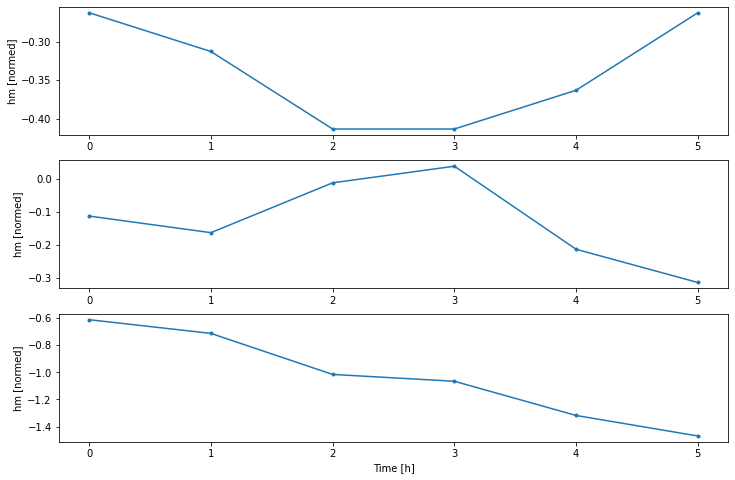

In [33]:
w2.plot(plot_col='hm')

### 4. `tf.data.Dataset` 만들기

마지막으로, 이 `make_dataset` 메서드는 시계열 `DataFrame`을 가져와 `preprocessing.timeseries_dataset_from_array` 함수를 이용해 `(input_window, label_window)` 쌍의 `tf.data.Dataset`로 변환합니다.

#### make_dataset

####tf.Dataset.map(function)

#### tf.keras.preprocessing.timeseries_dataset_from_array

In [34]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

`WindowGenerator` 객체는 훈련, 검증 및 테스트 데이터를 보유합니다. 위의 

---

`make_dataset` 메서드를 사용하여 `tf.data.Datasets`로 여기에 액세스하기 위한 

---

특성을 추가합니다. 또한 간편한 액세스와 플롯을 위한 표준 예제 배치를 추가합니다.

In [43]:
data = test_df
ds = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=data,
    targets=None,
    sequence_length=w2.total_window_size,
    sequence_stride=1,
    shuffle=True,
    batch_size=32,)

In [55]:
i = 0
for data in ds:
    input, target = w2.split_window(data)
    if not i:
        print(input.shape, target.shape)
    i += 1
print(f'total iteration: {i}')

(32, 6, 14) (32, 1, 1)
total iteration: 219


In [35]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

이제 `WindowGenerator` 객체가 `tf.data.Dataset` 객체에 대한 액세스 권한을 부여하므로 데이터를 쉽게 반복할 수 있습니다.

`Dataset.element_spec` 속성은 데이터세트 요소의 구조, `dtypes` 및 형상을 알려줍니다.

#### tf.Dataset.element_spec

In [36]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 14), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

`Dataset`를 반복하면 구체적인 배치가 생성됩니다.

#### tf.Dataset.take(counts)

In [37]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 14)
Labels shape (batch, time, features): (32, 1, 1)
